In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [3]:
df1 = pd.read_csv('../Data/DailyTotalFemaleBirths.csv', index_col='Date', parse_dates=True)
df1.index.freq = 'D'

df2 = pd.read_csv('../Data/TradeInventories.csv', index_col='Date', parse_dates=True)
df2.index.freq = 'MS'

#### Check for Augmented Dickey-Fuller test

In [4]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

#### ARMA

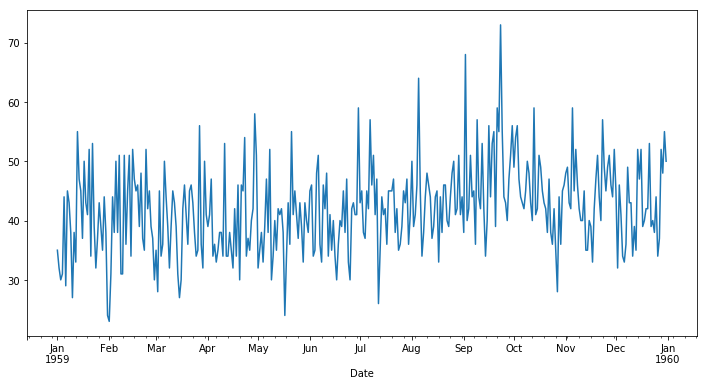

In [7]:
df1['Births'].plot(figsize=(12, 6));

In [5]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [11]:
# Determining the (p, q) ARMA orders
auto_arima(df1['Births']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.077
Date:                Sun, 28 Aug 2022   AIC                           2460.154
Time:                        16:44:41   BIC                           2475.743
Sample:                             0   HQIC                          2466.350
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0132      0.014      0.975      0.330      -0.013       0.040
ar.L1          0.1299      0.059      2.217      0.027       0.015       0.245
ma.L1         -0.9694      0.016    -62.235      0.000      -1.000      -0.939
sigma2        48.9989      3.432     14.279      0.000      42.273      55.725
===================================================================================
Ljung-Box (Q):                       36.69   Jarque-Bera (JB):                26.17
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.58
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
# train-test split
train = df1.iloc[:90]
test = df1.iloc[90:]

In [10]:
model = ARMA(train['Births'], order=(2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Sun, 28 Aug 2022   AIC                            627.809
Time:                        16:44:25   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.501      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.801      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.557      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7433           +0.0000j            1.7433            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

In [12]:
# Predict and compare with test data
start = len(train)
end = start + len(test) - 1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) PREDICTIONS')

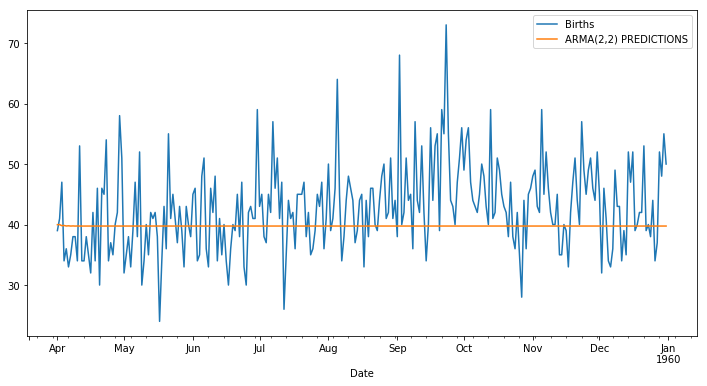

In [13]:
test['Births'].plot(figsize=(12, 6), legend=True)
predictions.plot(legend=True)

#### ARIMA

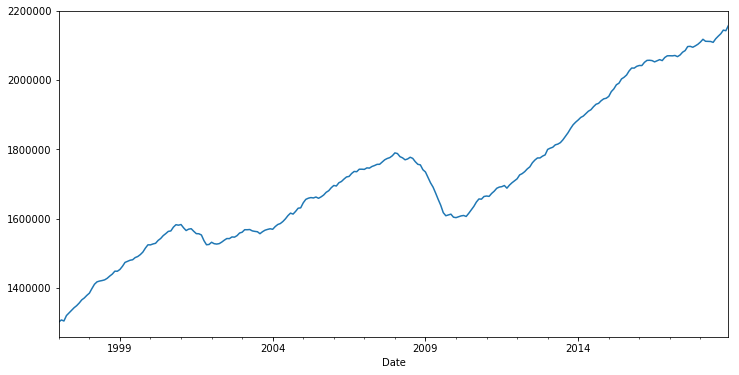

In [15]:
df2['Inventories'].plot(figsize=(12, 6)).autoscale(axis='x', tight=True)

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

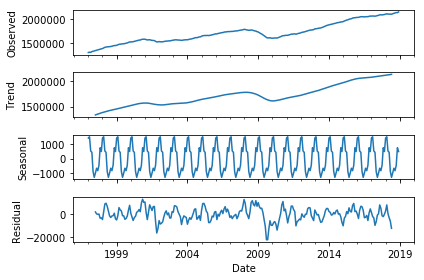

In [18]:
decomp = seasonal_decompose(df2['Inventories'], model='additive')
decomp.plot();

In [20]:
# The seasonal component doesn't contribute significantly to the series

In [21]:
auto_arima(df2['Inventories'], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.252
Method:                       css-mle   S.D. of innovations           4938.258
Date:                Sun, 28 Aug 2022   AIC                           5228.505
Time:                        16:50:31   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3472.9857   1313.669      2.644      0.009     898.241    6047.731
ar.L1.D.y      0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7446           +0.0000j            1.7446            0.0000
-----------------------------------------------------------------------------
"""

In [25]:
# Summary shows that there is an I component (I = 1) which indicates
# that there is a seasonal component which renders the series non-stationary
# we use the diff method to make the series stationary 

In [24]:
adf_test(df2['Inventories'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.087684
p-value                   0.950652
# lags used               5.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [22]:
from statsmodels.tsa.statespace.tools import diff

In [23]:
df2['d1'] = diff(df2['Inventories'], k_diff=1)

adf_test(df2['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#### ACF and PACF plots

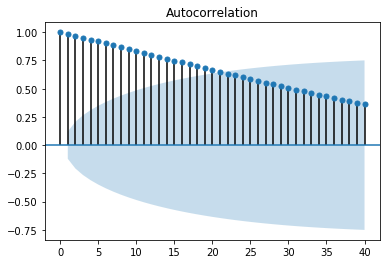

In [27]:
plot_acf(df2['Inventories'], lags=40);

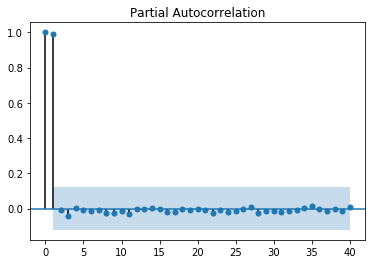

In [28]:
plot_pacf(df2['Inventories'], lags=40);

In [30]:
#If the PACF displays a sharp cutoff while the ACF decays more
#slowly (i.e., has significant spikes at higher lags), we say
#that the stationarized series displays an "AR signature," 
#meaning that the autocorrelation pattern can be explained more 
#easily by adding AR terms than by adding MA terms.

In [31]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=5348.037, BIC=5355.181, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5250.883, BIC=5261.599, Fit time=0.048 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5283.095, BIC=5293.811, Fit time=0.015 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5240.553, BIC=5254.842, Fit time=0.089 seconds
Fit ARIMA: order=(2, 1, 1); AIC=5229.528, BIC=5247.389, Fit time=0.091 seconds
Fit ARIMA: order=(1, 1, 1); AIC=5228.505, BIC=5242.794, Fit time=0.113 seconds
Fit ARIMA: order=(1, 1, 2); AIC=5229.289, BIC=5247.150, Fit time=0.181 seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.564 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.252
Method:                       css-mle   S.D. of innovations           4938.258
Date:                Sun, 28 Aug 2022   AIC                           5228.505
Time:                        16:55:06   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3472.9857   1313.669      2.644      0.009     898.241    6047.731
ar.L1.D.y      0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7446           +0.0000j            1.7446            0.0000
-----------------------------------------------------------------------------
"""

In [32]:
train = df2.iloc[:252]
test = df2.iloc[252:]

In [33]:
model = ARIMA(train['Inventories'], order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Sun, 28 Aug 2022   AIC                           4980.790
Time:                        16:56:03   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5697   1344.871      2.378      0.018     561.671    5833.468
ar.L1.D.Inventories     0.9026      0.039     23.010      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

In [34]:
start = len(train)
end = start + len(test) - 1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

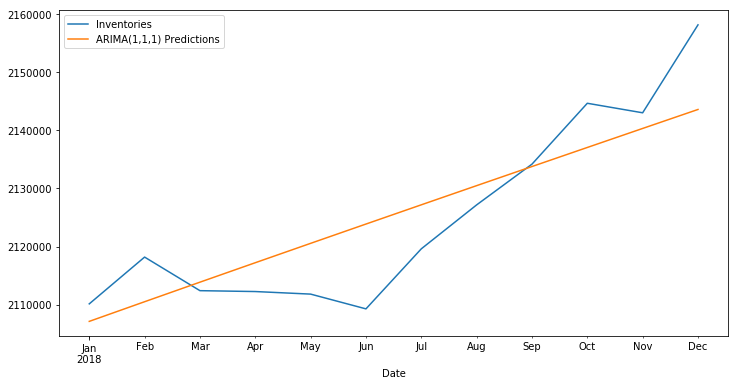

In [35]:
test['Inventories'].plot(legend=True, figsize=(12,6))
predictions.plot(legend=True)

In [36]:
# model evaluation
from sklearn.metrics import mean_squared_error

In [37]:
mean_squared_error(test['Inventories'], predictions)

60677824.72190262

In [38]:
from statsmodels.tools.eval_measures import rmse

rmse(test['Inventories'], predictions)

7789.597211788464

In [39]:
test['Inventories'].mean()

2125075.6666666665

In [40]:
predictions.mean()

2125465.270731611

#### Retrain model on the full data and forecast

In [41]:
model = ARIMA(df2['Inventories'], order=(1,1,1))
results = model.fit()

In [42]:
start = len(df2)
end = start + 11
forecast = results.predict(start=start, end=end, typ='levels').rename('ARIMA(1,1,1) FORECAST')

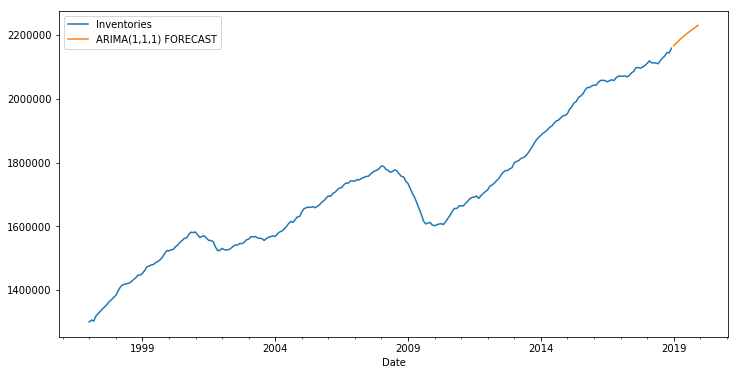

In [43]:
df2['Inventories'].plot(figsize=(12, 6), legend=True)
forecast.plot(legend=True)